In [1]:
import numpy as np 
import pandas as pd 
from data_processing import generate_vocab, process_data, create_dataloaders 
from model import get_pretrained_emb, EncoderDecoder, EncoderRNN, DecoderRNN, DecoderSimpleRNN, \
    Attention, DecoderAttnRNN
from train_eval import train_and_eval, inspect_model, count_parameters, summarize_results, \
    plot_single_learning_curve, load_experiment_log
from train_eval import train_and_eval_V2, tensor2corpus_V2
import importlib
import pickle as pkl 

In [34]:
# model identification
MODEL_NAME = 'test_model'
SRC_LANG = 'zh'
TARG_LANG = 'en'

# data processing params  
SRC_MAX_SENTENCE_LEN = 2
TARG_MAX_SENTENCE_LEN = 2
SRC_VOCAB_SIZE = 30000
TARG_VOCAB_SIZE = 30000

# model architecture params 
NUM_LAYERS = 1 #2 
ENC_HIDDEN_DIM = 300 
DEC_HIDDEN_DIM = 2 * ENC_HIDDEN_DIM 
TEACHER_FORCING_RATIO = 1
CLIP_GRAD_MAX_NORM = 10
ENC_DROPOUT = 0 # to actually implement
DEC_DROPOUT = 0 # to actually implement

# training params  
BATCH_SIZE = 16 #32
NUM_EPOCHS = 200
LR = 0.001 # 0.0005
OPTIMIZER = 'Adam'
LAZY_TRAIN = True 

In [35]:
# store as dict to save to results later 
params = {'model_name': MODEL_NAME, 'src_lang': SRC_LANG, 'targ_lang': TARG_LANG, 
          'src_max_sentence_len': SRC_MAX_SENTENCE_LEN, 'targ_max_sentence_len': TARG_MAX_SENTENCE_LEN, 
          'src_vocab_size': SRC_VOCAB_SIZE, 'targ_vocab_size': TARG_VOCAB_SIZE, 
          'num_layers': NUM_LAYERS, 'enc_hidden_dim': ENC_HIDDEN_DIM, 'dec_hidden_dim': DEC_HIDDEN_DIM,
          'teacher_forcing_ratio': TEACHER_FORCING_RATIO, 'clip_grad_max_norm': CLIP_GRAD_MAX_NORM,
          'enc_dropout': ENC_DROPOUT, 'dec_dropout': DEC_DROPOUT, 
          'batch_size': BATCH_SIZE, 'num_epochs': NUM_EPOCHS, 'learning_rate': LR, 'optimizer': OPTIMIZER, 
          'lazy_train': LAZY_TRAIN} 

In [36]:
# # takes a long time to process, save to pickle for reimport in future 
# vocab = generate_vocab(SRC_LANG, TARG_LANG, SRC_VOCAB_SIZE, TARG_VOCAB_SIZE)
# vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
# pkl.dump(vocab, open(vocab_filename, "wb"))

In [37]:
# reload from pickle 
vocab_filename = "{}-{}-vocab.p".format(SRC_LANG, TARG_LANG)
vocab = pkl.load(open(vocab_filename, "rb"))
data = process_data(SRC_LANG, TARG_LANG, vocab)
limited_data = process_data(SRC_LANG, TARG_LANG, vocab, sample_limit=BATCH_SIZE) 

In [38]:
# create dataloaders 
full_loaders = create_dataloaders(data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)
fast_loaders = create_dataloaders(limited_data, SRC_MAX_SENTENCE_LEN, TARG_MAX_SENTENCE_LEN, BATCH_SIZE)

In [39]:
# define model 

encoder = EncoderRNN(enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, src_max_sentence_len=SRC_MAX_SENTENCE_LEN,
                     pretrained_word2vec=get_pretrained_emb(vocab[SRC_LANG]['word2vec'], vocab[SRC_LANG]['token2id']))
# decoder = DecoderSimpleRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
#                            targ_vocab_size=TARG_VOCAB_SIZE, targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
#                            pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
decoder = DecoderAttnRNN(dec_hidden_dim=DEC_HIDDEN_DIM, enc_hidden_dim=ENC_HIDDEN_DIM, num_layers=NUM_LAYERS, 
                         targ_vocab_size=TARG_VOCAB_SIZE, src_max_sentence_len=SRC_MAX_SENTENCE_LEN, 
                         targ_max_sentence_len=TARG_MAX_SENTENCE_LEN, 
                         pretrained_word2vec=get_pretrained_emb(vocab[TARG_LANG]['word2vec'], vocab[TARG_LANG]['token2id']))
model = EncoderDecoder(encoder, decoder, vocab[TARG_LANG]['token2id']) 

In [40]:
model, results = train_and_eval_V2(
    model=model, full_loaders=full_loaders, fast_loaders=fast_loaders, params=params, vocab=vocab, 
    print_intermediate=True, save_checkpoint=True, lazy_eval=False, inspect_iter=100, save_to_log=True, print_summary=True)

Epoch: 0.00, Train Loss: 9.01, Val Loss: 9.94, Train BLEU: 44.31, Val BLEU: 1.00
Sampling from training predictions...
Source: 大部 大部分
Reference: most
Model: <SOS> and

Sampling from val predictions...
Source: 一个 真正
Reference: a
Model: <SOS> and

Epoch: 1.00, Train Loss: 7.70, Val Loss: 9.60, Train BLEU: 31.94, Val BLEU: 1.00
Sampling from training predictions...
Source: 海洋 里
Reference: the
Model: <SOS> and

Sampling from val predictions...
Source: 塔利 塔利班
Reference: &quot;
Model: <SOS> most

Epoch: 2.00, Train Loss: 6.30, Val Loss: 9.21, Train BLEU: 31.94, Val BLEU: 1.00
Sampling from training predictions...
Source: 原因 在于
Reference: and
Model: <SOS> and

Sampling from val predictions...
Source: 一个 真正
Reference: a
Model: <SOS> and

Epoch: 3.00, Train Loss: 4.94, Val Loss: 8.83, Train BLEU: 31.94, Val BLEU: 1.00
Sampling from training predictions...
Source: 泰坦 泰坦尼克
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 我 11
Reference: when
Model: <SOS> and

Epoch: 4.00,

Epoch: 34.00, Train Loss: 0.65, Val Loss: 11.80, Train BLEU: 81.44, Val BLEU: 7.19
Sampling from training predictions...
Source: 这儿 基本
Reference: it
Model: <SOS> and

Sampling from val predictions...
Source: 冬天 很
Reference: it
Model: <SOS> the

Epoch: 35.00, Train Loss: 0.61, Val Loss: 11.83, Train BLEU: 87.63, Val BLEU: 7.19
Sampling from training predictions...
Source: 大多 大多数
Reference: most
Model: <SOS> most

Sampling from val predictions...
Source: 我 6
Reference: you
Model: <SOS> most

Epoch: 36.00, Train Loss: 0.57, Val Loss: 11.86, Train BLEU: 87.63, Val BLEU: 7.19
Sampling from training predictions...
Source: 当 你
Reference: part
Model: <SOS> part

Sampling from val predictions...
Source: 塔利 塔利班
Reference: &quot;
Model: <SOS> most

Epoch: 37.00, Train Loss: 0.53, Val Loss: 11.87, Train BLEU: 87.63, Val BLEU: 13.38
Sampling from training predictions...
Source: 大家 想想
Reference: when
Model: <SOS> when

Sampling from val predictions...
Source: 他 面带
Reference: there
Model: <SOS> most


Epoch: 67.00, Train Loss: 0.11, Val Loss: 12.00, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 我们 这
Reference: we
Model: <SOS> we

Sampling from val predictions...
Source: 我们 把
Reference: we
Model: <SOS> we

Epoch: 68.00, Train Loss: 0.11, Val Loss: 12.00, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 其实 实地
Reference: and
Model: <SOS> and

Sampling from val predictions...
Source: 我 不知
Reference: i
Model: <SOS> when

Epoch: 69.00, Train Loss: 0.11, Val Loss: 12.00, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 海洋 里
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 这 是
Reference: it
Model: <SOS> part

Epoch: 70.00, Train Loss: 0.11, Val Loss: 12.00, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 当 你
Reference: part
Model: <SOS> part

Sampling from val predictions...
Source: 我 11
Reference: when
Model: <SOS> most

Epoch: 71.00, 

Epoch: 100.00, Train Loss: 0.09, Val Loss: 12.17, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 大部 大部分
Reference: most
Model: <SOS> most

Sampling from val predictions...
Source: 一个 真正
Reference: a
Model: <SOS> it

Epoch: 101.00, Train Loss: 0.09, Val Loss: 12.17, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 海洋 里
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 塔利 塔利班
Reference: &quot;
Model: <SOS> most

Epoch: 102.00, Train Loss: 0.09, Val Loss: 12.18, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 海洋 里
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 一个 真正
Reference: a
Model: <SOS> it

Epoch: 103.00, Train Loss: 0.09, Val Loss: 12.18, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 泰坦 泰坦尼克
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 我们 每天
Reference: each
Model: <SOS> it

Epoch: 133.00, Train Loss: 0.09, Val Loss: 12.24, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 当 你
Reference: part
Model: <SOS> part

Sampling from val predictions...
Source: 我们 每天
Reference: each
Model: <SOS> it

Epoch: 134.00, Train Loss: 0.09, Val Loss: 12.24, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 大卫 <UNK>
Reference: this
Model: <SOS> with

Sampling from val predictions...
Source: 冬天 很
Reference: it
Model: <SOS> the

Epoch: 135.00, Train Loss: 0.09, Val Loss: 12.24, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 大部 大部分
Reference: most
Model: <SOS> most

Sampling from val predictions...
Source: 我们 都
Reference: we
Model: <SOS> we

Epoch: 136.00, Train Loss: 0.09, Val Loss: 12.25, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 泰坦 泰坦尼克
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 我 不知
Reference: i
Model: <SOS> whe

Epoch: 166.00, Train Loss: 0.09, Val Loss: 12.31, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 海洋 的
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 我们 每天
Reference: each
Model: <SOS> it

Epoch: 167.00, Train Loss: 0.09, Val Loss: 12.32, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 这儿 基本
Reference: it
Model: <SOS> it

Sampling from val predictions...
Source: 我们 把
Reference: we
Model: <SOS> we

Epoch: 168.00, Train Loss: 0.09, Val Loss: 12.32, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 海洋 的
Reference: the
Model: <SOS> the

Sampling from val predictions...
Source: 这 是
Reference: it
Model: <SOS> part

Epoch: 169.00, Train Loss: 0.09, Val Loss: 12.32, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 原因 在于
Reference: and
Model: <SOS> and

Sampling from val predictions...
Source: 我 永远
Reference: a
Model: <SOS> and

Epoch: 170.0

Epoch: 199.00, Train Loss: 0.09, Val Loss: 12.36, Train BLEU: 93.81, Val BLEU: 19.56
Sampling from training predictions...
Source: 我们 这
Reference: we
Model: <SOS> we

Sampling from val predictions...
Source: 学校 在
Reference: the
Model: <SOS> the

Experiment completed in 1 minutes with 8.61 best validation loss and 19.56 best validation BLEU.


In [41]:
summarize_results(load_experiment_log())

,dt_created,experiment_name,hyperparams,results,runtime,model_type,num_epochs,learning_rate,enc_hidden_dim,dec_hidden_dim,...,targ_lang,src_vocab_size,targ_vocab_size,src_max_sentence_len,targ_max_sentence_len,model_name,teacher_forcing_ratio,lazy_train,clip_grad_max_norm,val_loss
16,2018-12-01 22:55:23,test_model,"{'model_name': 'test_model', 'src_lang': 'zh',...","[{'epoch': 0.0, 'val_loss': 9.943002700805664,...",1.639537,NaN,200,0.0010,300,600,...,en,30000,30000,2,2,test_model,1.0,True,10.0,8.607852
15,2018-12-01 22:48:41,test_model,"{'model_name': 'test_model', 'src_lang': 'zh',...","[{'epoch': 0.0, 'val_loss': 10.132436752319336...",2.042285,NaN,200,0.0010,300,600,...,en,30000,30000,3,3,test_model,1.0,True,10.0,9.221855
14,2018-12-01 22:21:40,test_model,"{'model_name': 'test_model', 'src_lang': 'zh',...","[{'epoch': 0.0, 'val_loss': 10.104202270507812...",1.560579,NaN,200,0.0010,300,600,...,en,30000,30000,2,2,test_model,0.5,True,10.0,8.778268
13,2018-12-01 21:52:06,test_model,"{'model_name': 'test_model', 'src_lang': 'zh',...","[{'epoch': 0.0, 'val_loss': 10.228408813476562...",7.566348,NaN,200,0.0010,300,600,...,en,30000,30000,10,10,test_model,0.5,True,10.0,9.359420
12,2018-12-01 15:20:22,test_model,"{'model_name': 'test_model', 'src_lang': 'vi',...","[{'epoch': 0.0, 'val_loss': 10.160977363586426...",8.699158,NaN,200,0.0010,300,600,...,en,30000,30000,10,10,test_model,0.5,True,10.0,8.283567
11,2018-12-01 02:57:58,test_model,"{'model_name': 'test_model', 'src_lang': 'vi',...","[{'epoch': 0.0, 'val_loss': 10.246160507202148...",0.264690,NaN,5,0.0005,300,600,...,en,30000,30000,10,10,test_model,0.5,True,10.0,9.577247
10,2018-12-01 02:38:47,test_model,"{'model_name': 'test_model', 'src_lang': 'vi',...","[{'epoch': 0.0, 'val_loss': 10.238265037536621...",0.309454,NaN,5,0.0005,300,600,...,en,30000,30000,10,10,test_model,0.5,True,10.0,9.337175
9,2018-12-01 02:29:11,test_model,"{'model_name': 'test_model', 'num_epochs': 5, ...","[{'epoch': 0.0, 'val_loss': 10.221494674682617...",0.312100,NaN,5,0.0005,300,600,...,en,30000,30000,10,10,test_model,0.5,True,10.0,9.228798
8,2018-12-01 02:22:55,test_model,"{'model_name': 'test_model', 'num_epochs': 5, ...","[{'epoch': 0.0, 'val_loss': 10.231721878051758...",0.381173,NaN,5,0.0005,300,600,...,en,30000,30000,10,10,test_model,0.5,True,NaN,9.330558
7,2018-11-28 17:55:24,test_run,"{'model_type': 'attention_bahdanau', 'num_epoc...","[{'epoch': 0.0, 'val_loss': 10.21630573272705,...",6.029234,attention_bahdanau,100,0.0005,300,600,...,en,30000,30000,10,10,NaN,NaN,NaN,NaN,8.507013


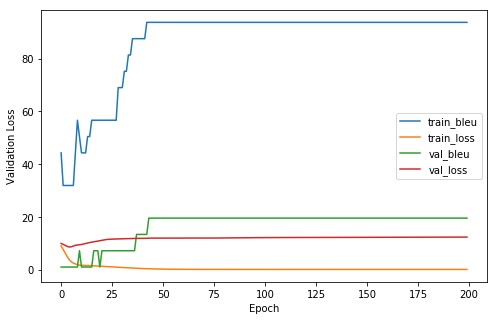

In [42]:
plot_single_learning_curve(results)

In [ ]:
for i, (src_idxs, targ_idxs, src_lens, targ_lens) in enumerate(full_loaders['train']):
#     print(i)
#     print(src_idxs.size())
#     print(src_idxs)
#     print(src_lens)
#     print(targ_idxs.size())
#     print(targ_idxs)
#     print(targ_lens)
    id2token = vocab[SRC_LANG]['id2token']
    test_tensor = src_idxs
    list_of_lists = test_tensor.numpy().astype(int).tolist()
    to_token = lambda l: ' '.join([id2token[idx] for idx in l])
    list_of_lists_tokens = [to_token(l) for l in list_of_lists] 
    break 